<a href="https://colab.research.google.com/github/alaeddinehamroun/Sign-Language-MNIST/blob/main/Neural_Networks_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working on the Sign Language MNIST:

In this notebook, I am going to try and classify images from the Sign Language MNIST
dataset using different models and techniques that i've learned from the [DeepLearning.AI TensorFlow Developer Professional Certificate course](https://www.coursera.org/professional-certificates/tensorflow-in-practice).

I actually got 0.999 testing accuracy using transfer learning. 

In [2]:
import csv
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

# About the Data
The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods but researchers have renewed efforts to update it and develop drop-in replacements that are more challenging for computer vision and original for real-world applications. As noted in one recent replacement called the Fashion-MNIST dataset, the Zalando researchers quoted the startling claim that "Most pairs of MNIST digits (784 total pixels per sample) can be distinguished pretty well by just one pixel". To stimulate the community to develop more drop-in replacements, the Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

# Load the data

In [3]:
# sign_mnist_train.csv
!gdown --id 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown --id 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 87.6MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 237MB/s]


In [4]:
train_data = pd.read_csv('./sign_mnist_train.csv')
test_data = pd.read_csv('./sign_mnist_test.csv')

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [6]:
train_data.shape

(27455, 785)

In [7]:
type(train_data)

pandas.core.frame.DataFrame

# Train/test Split

In [8]:
def split_data(source_data, SPLIT_SIZE):
  train_length = int(len(source_data)*SPLIT_SIZE)
  test_length = int(len(source_data) -  train_length)
  
  #shuffle the data
  source_data = source_data.sample(frac = 1)
  
  #split the data
  train_data = source_data[0: train_length]
  validation_data = source_data[-test_length:]

  return train_data, validation_data



SPLIT_SIZE = .9
train_data, validation_data = split_data(train_data, SPLIT_SIZE)


In [9]:
print(train_data.shape)
print(validation_data.shape)

(24709, 785)
(2746, 785)


Alternatively, we can use the train_test_split method provided by sklearn:


In [10]:
#from sklearn.model_selection import train_test_split
#train_data, validation_data = train_test_split(train_data, test_size = 0.1, random_state = 101)

# Parsing the Dataset

In [11]:
#train_data.drop('label', axis=1, inplace=True)
#np.array([np.reshape(i, (28, 28)) for i in train_data.values]).astype(np.float64)

In [12]:
def parse_data(data):
  
  labels = data['label'].values
  data.drop('label', axis=1, inplace=True)
  
  images = data.values
  images = np.array([np.reshape(i, (28, 28)) for i in images])
  
  labels = np.array(labels).astype(np.float64)
  images = np.array(images).astype(np.float64)

  return images, labels

In [13]:
training_images, training_labels = parse_data(train_data)
validation_images, validation_labels = parse_data(validation_data)
testing_images, testing_labels = parse_data(test_data)

In [14]:
print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")

print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

print(f"Testing images has shape: {testing_images.shape} and dtype: {testing_images.dtype}")
print(f"Testing labels has shape: {testing_labels.shape} and dtype: {testing_labels.dtype}")

Training images has shape: (24709, 28, 28) and dtype: float64
Training labels has shape: (24709,) and dtype: float64
Validation images has shape: (2746, 28, 28) and dtype: float64
Validation labels has shape: (2746,) and dtype: float64
Testing images has shape: (7172, 28, 28) and dtype: float64
Testing labels has shape: (7172,) and dtype: float64


# Visualizing the Data

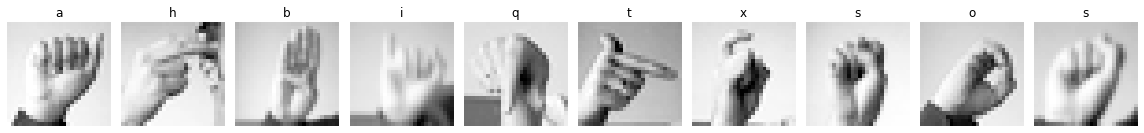

In [15]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

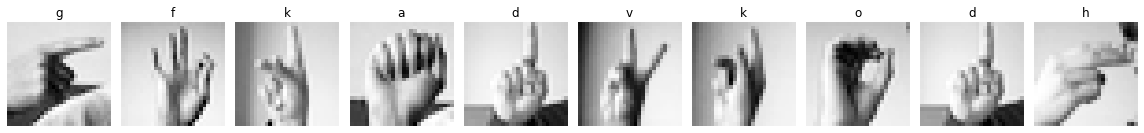

In [16]:
plot_categories(testing_images, testing_labels)

# Data augmentation

In [17]:
def data_preprocessing(training_images, validation_images, TL=False):
   #add another dimension to the data
  training_images = np.expand_dims(training_images, axis=3)
  validation_images = np.expand_dims(validation_images, axis=3)
  if (TL):
    training_images = tf.image.resize(training_images, (120, 120))
    validation_images = tf.image.resize(validation_images, (120, 120))

    training_images = tf.image.grayscale_to_rgb(training_images)
    validation_images = tf.image.grayscale_to_rgb(validation_images)
  return training_images, validation_images

In [18]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  
  #Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=False,
                                     fill_mode='nearest')
  validation_datagen = ImageDataGenerator(rescale=1./255)

  #generate batches of augmented data using the flow method
  train_generator = train_datagen.flow(x=training_images,
                                       y=training_labels,
                                       batch_size=128)
  validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels,
                                                 batch_size=128)
  
  return train_generator, validation_generator

In [19]:
cnn_training_images, cnn_validation_images = data_preprocessing(training_images, validation_images, TL=False)

In [20]:
print(f"Training images for CNN has shape: {cnn_training_images.shape} and dtype: {cnn_training_images.dtype}")

print(f"Validation images for CNN has shape: {cnn_validation_images.shape} and dtype: {cnn_validation_images.dtype}")

Training images for CNN has shape: (24709, 28, 28, 1) and dtype: float64
Validation images for CNN has shape: (2746, 28, 28, 1) and dtype: float64


In [21]:
train_generator, validation_generator = train_val_generators(cnn_training_images, training_labels, cnn_validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (24709, 28, 28, 1)
Labels of training generator have shape: (24709,)
Images of validation generator have shape: (2746, 28, 28, 1)
Labels of validation generator have shape: (2746,)


In [22]:
print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")

Training images has shape: (24709, 28, 28) and dtype: float64
Validation images has shape: (2746, 28, 28) and dtype: float64


# CNN Model

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=5, min_lr=0.00001)

In [24]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [25]:
def create_model():

  ### START CODE HERE       

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(126, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax')
])

  

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  ### END CODE HERE       
  
  return model

In [26]:
model = create_model()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 126)               2

In [ ]:
# Train your model
callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks= [callbacks, reduce_lr])

Epoch 1/20
194/194 [==============================] - 18s 36ms/step - loss: 2.9075 - accuracy: 0.1399 - val_loss: 1.8825 - val_accuracy: 0.4476 - lr: 0.0010
Epoch 2/20
194/194 [==============================] - 12s 62ms/step - loss: 2.1079 - accuracy: 0.3557 - val_loss: 1.2863 - val_accuracy: 0.5605 - lr: 0.0010
Epoch 3/20
194/194 [==============================] - 7s 34ms/step - loss: 1.6636 - accuracy: 0.4774 - val_loss: 0.8312 - val_accuracy: 0.7571 - lr: 0.0010
Epoch 4/20
194/194 [==============================] - 19s 97ms/step - loss: 1.4316 - accuracy: 0.5409 - val_loss: 0.6558 - val_accuracy: 0.8077 - lr: 0.0010
Epoch 5/20
194/194 [==============================] - 15s 75ms/step - loss: 1.2544 - accuracy: 0.5978 - val_loss: 0.6565 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 6/20
194/194 [==============================] - 13s 68ms/step - loss: 1.1344 - accuracy: 0.6339 - val_loss: 0.5919 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 7/20
194/194 [==============================] - 13s 6

In [33]:
# Plot the chart for accuracy and loss on both training and validation
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

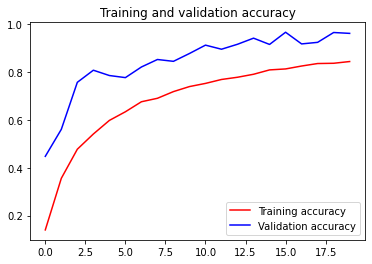

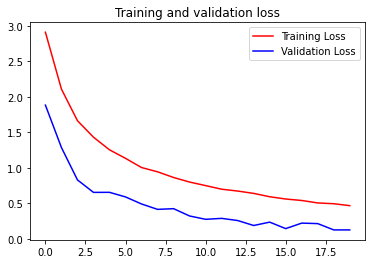

In [ ]:
plot_accuracy_and_loss(history)

In [37]:
from sklearn.metrics import accuracy_score
def make_predictions(model):
  predictions = model.predict(testing_images)
  pred = np.argmax(predictions, axis=1)
  print(accuracy_score(testing_labels, pred))

In [ ]:
make_predictions(model)

0.7339654210819855


# Using Transfer learning

In [18]:
tl_training_images, tl_validation_images = data_preprocessing(training_images, validation_images, TL=True)

In [19]:
print(f"Training images for TL has shape: {tl_training_images.shape} and dtype: {tl_training_images.dtype}")
print(f"Validation images for TL has shape: {tl_validation_images.shape} and dtype: {tl_validation_images.dtype}")

Training images for TL has shape: (24709, 120, 120, 3) and dtype: <dtype: 'float32'>
Validation images for TL has shape: (2746, 120, 120, 3) and dtype: <dtype: 'float32'>


In [20]:
tl_train_generator, tl_validation_generator = train_val_generators(tl_training_images, training_labels, tl_validation_images, validation_labels)

print(f"Images of training generator have shape: {tl_train_generator.x.shape}")
print(f"Labels of training generator have shape: {tl_train_generator.y.shape}")
print(f"Images of validation generator have shape: {tl_validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {tl_validation_generator.y.shape}")

Images of training generator have shape: (24709, 120, 120, 3)
Labels of training generator have shape: (24709,)
Images of validation generator have shape: (2746, 120, 120, 3)
Labels of validation generator have shape: (2746,)


In [21]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-29 19:43:35--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  36.9MB/s    in 2.3s    

2022-06-29 19:43:39 (36.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [22]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [23]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (120, 120, 3),
                                  include_top = False, 
                                  weights = None) 
  
  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False
  
  return pre_trained_model


In [24]:
pre_trained_model = create_pre_trained_model(local_weights_file)

In [ ]:
pre_trained_model.summary()

In [25]:
#Check that all layers in the model were set to be non-trainable
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


Pipelining the pre-trained model with yout own:

In [26]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [27]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 5, 5, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [28]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [29]:
def create_final_model(pre_trained_model, last_output):
  x = tf.keras.layers.Flatten()(last_output)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(26, activation='softmax')(x)

  model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [30]:
tl_model = create_final_model(pre_trained_model, last_output)

total_params = tl_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in tl_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 28,663,738 total parameters in this model.
There are 19,688,474 trainable parameters in this model.


In [31]:
callbacks = myCallback()
history = tl_model.fit(tl_train_generator,
                    epochs=20,
                    validation_data=tl_validation_generator,
                    callbacks= [callbacks, reduce_lr])

Epoch 1/20
194/194 [==============================] - 104s 461ms/step - loss: 0.6912 - accuracy: 0.8174 - val_loss: 0.0367 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 2/20
194/194 [==============================] - 85s 436ms/step - loss: 0.1871 - accuracy: 0.9405 - val_loss: 0.0128 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 3/20
194/194 [==============================] - 85s 436ms/step - loss: 0.1273 - accuracy: 0.9575 - val_loss: 0.0134 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 4/20
194/194 [==============================] - 85s 435ms/step - loss: 0.0989 - accuracy: 0.9677 - val_loss: 0.0037 - val_accuracy: 0.9996 - lr: 0.0010
Epoch 5/20
194/194 [==============================] - 84s 432ms/step - loss: 0.1074 - accuracy: 0.9666 - val_loss: 0.0084 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 6/20
194/194 [==============================] - 85s 438ms/step - loss: 0.0996 - accuracy: 0.9668 - val_loss: 0.0049 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 7/20
194/194 [==============================]

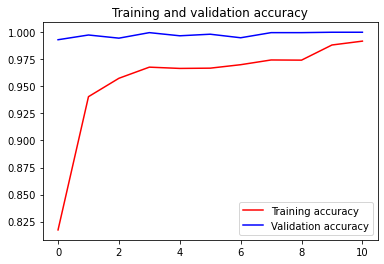

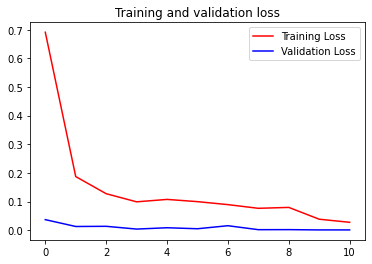

In [34]:
plot_accuracy_and_loss(history)

In [50]:
testing_images = np.expand_dims(testing_images, axis=3)
print(testing_images.shape)
testing_images = tf.image.resize(testing_images, (120, 120))
print(testing_images.shape)
testing_images = tf.image.grayscale_to_rgb(testing_images)
print(testing_images.shape)


(7172, 28, 28, 1)
(7172, 120, 120, 1)
(7172, 120, 120, 3)
(7172, 120, 120, 3)


In [53]:
testing_images = testing_images /255
print(testing_images.shape)
print(testing_images[0])

(7172, 120, 120, 3)
tf.Tensor(
[[[0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]
  ...
  [0.5846405  0.5846405  0.5846405 ]
  [0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]]

 [[0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]
  ...
  [0.5846405  0.5846405  0.5846405 ]
  [0.58431375 0.58431375 0.58431375]
  [0.58431375 0.58431375 0.58431375]]

 [[0.5846405  0.5846405  0.5846405 ]
  [0.5846405  0.5846405  0.5846405 ]
  [0.5846405  0.5846405  0.5846405 ]
  ...
  [0.58523965 0.58523965 0.58523965]
  [0.5849673  0.5849673  0.5849673 ]
  [0.5849673  0.5849673  0.5849673 ]]

 ...

 [[0.29379085 0.29379085 0.29379085]
  [0.29379085 0.29379085 0.29379085]
  [0.2935185  0.2935185  0.2935185 ]
  ...
  [0.4255447  0.4255447  0.4255447 ]
  [0.42156863 0.42156863 0.42156863]
  [0.42156863 0.42156863 0.42156863]]

 [[0.29411766 0.29411766 0.29411766]
  [0.2

In [54]:
print(tl_model.predict(testing_images))

[[4.87765087e-16 6.94189541e-12 3.45606956e-08 ... 5.32877301e-12
  2.44388277e-11 1.69173469e-14]
 [3.72862331e-12 8.28774319e-06 7.49319773e-11 ... 4.30088083e-11
  2.52539877e-07 5.86034409e-16]
 [1.74150057e-17 3.39877317e-16 2.95259664e-19 ... 2.22299926e-17
  7.52622909e-15 3.20045452e-20]
 ...
 [2.22450418e-15 1.24607156e-11 9.99962091e-01 ... 4.57781122e-12
  6.71196795e-16 4.69918560e-17]
 [9.90584592e-09 2.59866506e-09 4.67165959e-11 ... 2.35250708e-10
  5.03633080e-10 2.88520878e-12]
 [4.10965610e-19 2.11557293e-13 9.99999881e-01 ... 6.10011402e-15
  2.97297501e-19 1.18332524e-20]]


In [55]:
make_predictions(tl_model)

0.9991634132738427
